trying to load weights from /home/research/Datasets/NormalNet/ICCV2019_MirrorNet/backbone/resnext/resnext_101_32x4d.pth
Load ResNeXt Weights Succeed!
trying to load weights from /home/research/Datasets/NormalNet/ICCV2019_MirrorNet/backbone/resnext/resnext_101_32x4d.pth
Load ResNeXt Weights Succeed!
trying to load weights from /home/research/Datasets/NormalNet/ICCV2019_MirrorNet/backbone/resnext/resnext_101_32x4d.pth
Load ResNeXt Weights Succeed!
trying to load weights from /home/research/Datasets/NormalNet/ICCV2019_MirrorNet/backbone/resnext/resnext_101_32x4d.pth
Load ResNeXt Weights Succeed!
trying to load weights from /home/research/Datasets/NormalNet/ICCV2019_MirrorNet/backbone/resnext/resnext_101_32x4d.pth
Load ResNeXt Weights Succeed!
trying to load weights from /home/research/Datasets/NormalNet/ICCV2019_MirrorNet/backbone/resnext/resnext_101_32x4d.pth
Load ResNeXt Weights Succeed!
trying to load weights from /home/research/Datasets/NormalNet/ICCV2019_MirrorNet/backbone/resnext/re

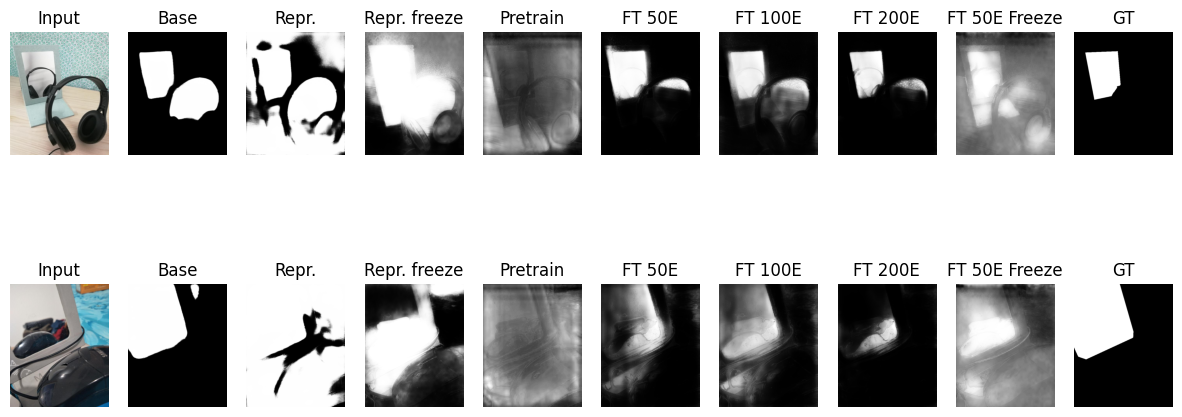

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from PIL import Image
from torch.autograd import Variable
from torchvision import transforms

from mirrornet import MirrorNet
from misc import crf_refine
# from config import msd_testing_root

args = {"snapshot": "160", "scale": 384, "crf": True}
pretrain_directory = "/home/research/Datasets/NormalNet/dataset"
data_root = "/home/research/Datasets/NormalNet/MSD/test"
ckpt_path = "./final_results"
exp_name = "MirrorNet"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 30
learning_rate = 0.001
momentum = 0.9
power = 0.9
DIM = 384
pretrained_path = os.path.join(
    ckpt_path, f"{exp_name}_frozen_backbone_pretrain_e100.pth"
)
f1p = os.path.join(
    ckpt_path, f"{exp_name}_finetuned_e50_frozen_backbone_pretrain_e100.pth"
)
f2p = os.path.join(
    ckpt_path, f"{exp_name}_finetuned_e100_frozen_backbone_pretrain_e100.pth"
)
f3p = os.path.join(
    ckpt_path, f"{exp_name}_finetuned_e200_frozen_backbone_pretrain_e100.pth"
)

base_y = os.path.join(ckpt_path, f"{exp_name}_base.pth")
base = os.path.join(ckpt_path, f"{exp_name}_BASE.pth")
basev2 = os.path.join(ckpt_path, f"{exp_name}_BASE_V2.pth")
low = os.path.join(ckpt_path, f"{exp_name}_BASE_bs10_frozen.pth")
low2 = os.path.join(ckpt_path, f"{exp_name}_e200_frozen.pth")
# model_paths = [pretrained_path, f1p, f2p, f3p, base, basev2, low]
model_paths = [base_y, base, low, pretrained_path,f1p, f2p, f3p,low2]
labels = ["Base", "Repr.", "Repr. freeze", "Pretrain","FT 50E", "FT 100E", "FT 200E" ,"FT 50E Freeze"]

img_transform = transforms.Compose(
    [
        transforms.Resize((args["scale"], args["scale"])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

to_pil = transforms.ToPILImage()
test_image_dir = os.path.join(data_root, "image")
test_mask_dir = os.path.join(data_root, "mask")

num_images = 2
num_models = len(model_paths) + 2  # how many columns

fig, axs = plt.subplots(num_images, num_models, figsize=(15, num_images * 3))

pixel_l1 = {}


with torch.no_grad():
    for i, img_name in enumerate(sorted(os.listdir(test_image_dir))[:num_images]):
        base_name = os.path.splitext(img_name)[0]
        img_path = os.path.join(test_image_dir, img_name)
        mask_path = os.path.join(test_mask_dir, f"{base_name}.png")

        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        img_var = Variable(img_transform(img).unsqueeze(0)).to(device)

        # Display the input image
        axs[i, 0].imshow(img)
        axs[i, 0].set_title("Input")
        axs[i, 0].axis("off")

        for m, model_path in enumerate(model_paths):
            net = MirrorNet(
                backbone_path="/home/research/Datasets/NormalNet/ICCV2019_MirrorNet/backbone/resnext/resnext_101_32x4d.pth"
            ).to(device)
            net.load_state_dict(torch.load(model_path, map_location=device))
            net.eval()

            f_4, f_3, f_2, f_1 = net(img_var)
            # f_1 = torch.sigmoid(f_1) > 0.5
            f_1 = f_1.data.squeeze(0).cpu()
            # output_img = np.array(to_pil(f_1))
            f_1 = np.array(transforms.Resize((h, w))(to_pil(f_1)))
            if args["crf"]:
                f_1 = crf_refine(np.array(img.convert("RGB")), f_1)
            output_img = f_1

            # Optionally resize output_img back to original dimensions if necessary

            axs[i, m + 1].imshow(output_img, cmap="gray")
            axs[i, m + 1].set_title(labels[m])
            # axs[i, m + 1].set_title(f"Model {m+1} Output")
            axs[i, m + 1].axis("off")

            # compute pixel wise L1

        # Load and display ground truth mask
        true_mask = Image.open(mask_path)
        axs[i, -1].imshow(true_mask, cmap="gray")
        axs[i, -1].set_title("GT")
        axs[i, -1].axis("off")
plt.show()
# plt.savefig(f"./final_results/final_output_GOOD.png")
